# YOLO_강아지 얼굴 인식



## YOLO_기초 세팅

In [34]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## YOLO_데이터 확인

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일 경로 설정

zip_path = "/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog.v9i.yolov8.zip"
extract_path = "/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face"

In [ ]:
# 프로젝트 구글 드라이브에 압축 해제

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# train 폴더 폴더명 변경

import os
import shutil

# 기존 train 경로
train_path = os.path.join(extract_path, "train")
new_data_path = os.path.join(extract_path, "data")

# 폴더명이 'train'일 때만 바꾸기
if os.path.exists(train_path):
    shutil.move(train_path, new_data_path)

In [ ]:
# 클래스 확인

import os

# 라벨 폴더 경로
labels_dir = f"{extract_path}/data/labels"

# 클래스 ID 모을 집합
class_ids = set()

# 라벨 파일들 순회
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():  # 빈 줄 제외
                    class_id = int(line.strip().split()[0])
                    class_ids.add(class_id)

# 결과 출력
print("클래스 유니크 값:", sorted(class_ids))

클래스 유니크 값: [0]


In [ ]:
# 얼굴 클래스 유니크 값이 0뿐임을 확인, 얼굴이 포함된 이미지만 존재
# 얼굴 위치를 정확히 포착했을 경우 TP
# 얼굴 위치가 아닌 다른 위치를 포착했을 경우 FP
# 얼굴 위치를 예측하지 못했을 경우 FN

## YOLO_모델 학습

In [ ]:
# 학습 / 검증 데이터 분할

import random
import shutil

# 경로 설정
base_path = os.path.join(extract_path, "data")
img_dir = os.path.join(base_path, "images")
label_dir = os.path.join(base_path, "labels")

# 2. train/val 분할 (80% train, 20% val)
train_img_dir = os.path.join(extract_path, "train", "images")
train_label_dir = os.path.join(extract_path, "train", "labels")
val_img_dir = os.path.join(extract_path, "valid", "images")
val_label_dir = os.path.join(extract_path, "valid", "labels")

for d in [train_img_dir, train_label_dir, val_img_dir, val_label_dir]:
    os.makedirs(d, exist_ok=True)

img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

random.seed(42)
random.shuffle(img_files)
split_idx = int(len(img_files) * 0.8)
train_files = img_files[:split_idx]
val_files = img_files[split_idx:]

def move_files(file_list, img_src, label_src, img_dst, label_dst):
    for f in file_list:
        shutil.move(os.path.join(img_src, f), os.path.join(img_dst, f))
        label_file = os.path.splitext(f)[0] + ".txt"
        if os.path.exists(os.path.join(label_src, label_file)):
            shutil.move(os.path.join(label_src, label_file), os.path.join(label_dst, label_file))
        else:
            print(f"Warning: 라벨 파일 없음 - {label_file}")

move_files(train_files, img_dir, label_dir, train_img_dir, train_label_dir)
move_files(val_files, img_dir, label_dir, val_img_dir, val_label_dir)
print(f"Train/Validation 분할 완료 (train: {len(train_files)}, val: {len(val_files)})")

Train/Validation 분할 완료 (train: 1886, val: 472)


In [ ]:
# 기존 YAML 파일 경로 지정

yaml_path = f"{extract_path}/data.yaml"

In [ ]:
# 모델 학습

from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data=yaml_path,
    epochs=20,
    imgsz=640
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 100MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 85.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.3 ms, read: 13.6±5.1 MB/s, size: 31.9 KB)


train: Scanning /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/train/labels... 1886 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1886/1886 [00:24<00:00, 76.80it/s] 


train: New cache created: /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.2±2.0 ms, read: 9.7±5.4 MB/s, size: 29.0 KB)


val: Scanning /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid/labels... 472 images, 1 backgrounds, 0 corrupt: 100%|██████████| 472/472 [00:05<00:00, 85.29it/s] 


val: New cache created: /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.09G      1.225      2.056      1.497         27        640: 100%|██████████| 118/118 [00:41<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]

                   all        472        471      0.665      0.618       0.68      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.57G      1.332      1.626      1.538         21        640: 100%|██████████| 118/118 [00:38<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]

                   all        472        471      0.619      0.517      0.566      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.59G      1.384      1.441      1.583         18        640: 100%|██████████| 118/118 [00:38<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

                   all        472        471      0.445      0.356      0.339      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.61G      1.381      1.364      1.566         39        640: 100%|██████████| 118/118 [00:38<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]

                   all        472        471      0.764      0.748      0.801      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.62G      1.334      1.225      1.531         32        640: 100%|██████████| 118/118 [00:37<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]

                   all        472        471      0.855      0.845      0.903       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.64G      1.263      1.142      1.474         29        640: 100%|██████████| 118/118 [00:37<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

                   all        472        471      0.867      0.804      0.895      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.66G      1.222      1.053      1.439         28        640: 100%|██████████| 118/118 [00:38<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.03it/s]

                   all        472        471      0.843      0.843      0.909      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.67G       1.18      1.021      1.414         29        640: 100%|██████████| 118/118 [00:38<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]

                   all        472        471      0.864      0.824      0.918      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.69G      1.142     0.9791      1.402         38        640: 100%|██████████| 118/118 [00:37<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]

                   all        472        471      0.895      0.905      0.955      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.71G       1.09     0.8992      1.351         27        640: 100%|██████████| 118/118 [00:36<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]

                   all        472        471      0.907      0.898      0.952      0.644


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.72G     0.9957      0.694      1.356         14        640: 100%|██████████| 118/118 [00:36<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

                   all        472        471      0.918      0.909      0.956      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.74G     0.9805     0.6568       1.35         14        640: 100%|██████████| 118/118 [00:34<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]

                   all        472        471      0.946      0.933      0.975      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.76G     0.9182     0.6036      1.298         14        640: 100%|██████████| 118/118 [00:35<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


                   all        472        471      0.942      0.962      0.981      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.78G     0.8768     0.5613      1.264         14        640: 100%|██████████| 118/118 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]

                   all        472        471      0.948      0.943      0.978      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.79G     0.8499     0.5295      1.228         14        640: 100%|██████████| 118/118 [00:34<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]

                   all        472        471       0.95      0.936       0.98      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.81G     0.7992     0.4921      1.197         14        640: 100%|██████████| 118/118 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

                   all        472        471      0.961      0.949       0.98      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.83G     0.7843     0.4792      1.185         14        640: 100%|██████████| 118/118 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]

                   all        472        471      0.966      0.953      0.985      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.85G     0.7408     0.4494       1.15         14        640: 100%|██████████| 118/118 [00:34<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]

                   all        472        471      0.974      0.957      0.987      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.86G     0.6986     0.4156      1.123         14        640: 100%|██████████| 118/118 [00:35<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.38it/s]

                   all        472        471      0.974      0.962      0.988      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.88G     0.6887     0.4029      1.118         14        640: 100%|██████████| 118/118 [00:34<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

                   all        472        471      0.976      0.964      0.991      0.802



20 epochs completed in 0.234 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


                   all        472        471      0.976      0.964      0.991      0.802
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d63a213f590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## YOLO_성능 확인 및 최적화

In [ ]:
# 학습 후 검증 및 결과 확인

metrics = model.val(data=yaml_path)
print(metrics)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 13.9±4.6 MB/s, size: 23.0 KB)


val: Scanning /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid/labels.cache... 472 images, 1 backgrounds, 0 corrupt: 100%|██████████| 472/472 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


                   all        472        471      0.976      0.964      0.991      0.803
Speed: 2.1ms preprocess, 4.7ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train32
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1c4ef2c5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03

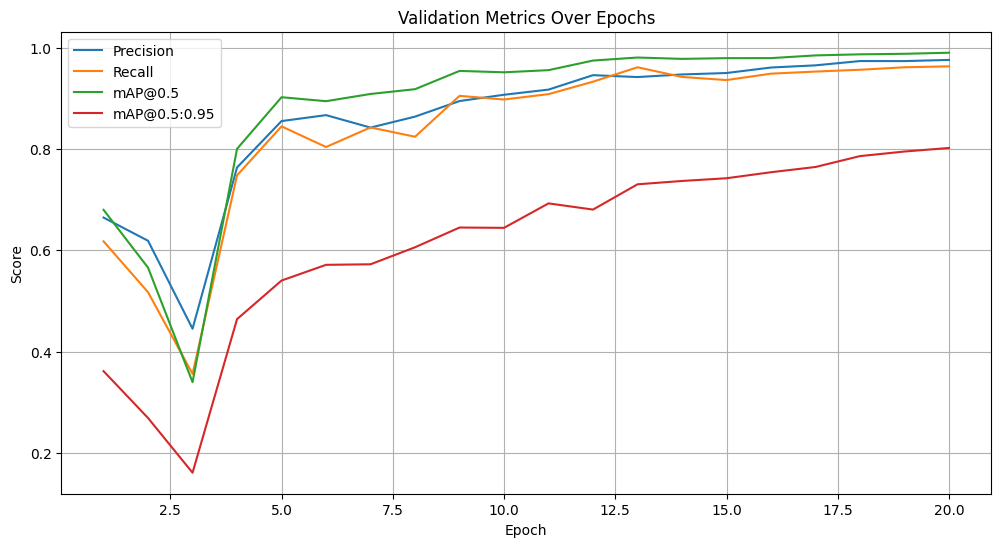

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# results.csv 경로
csv_path = 'runs/detect/train/results.csv'

# CSV 로드
performance = pd.read_csv(csv_path)

# 주요 성능 지표 시각화
plt.figure(figsize=(12, 6))
plt.plot(performance['epoch'], performance['metrics/precision(B)'], label='Precision')
plt.plot(performance['epoch'], performance['metrics/recall(B)'], label='Recall')
plt.plot(performance['epoch'], performance['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(performance['epoch'], performance['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 준수한 성능 확인 가능

In [ ]:
# 에포크별 성능 지표 요약


performance[['epoch', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']]

# 준수한 성능 확인 가능

,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
0,1,0.66475,0.61783,0.68003,0.36128
1,2,0.61892,0.51723,0.56574,0.26863
2,3,0.44502,0.35582,0.33943,0.16051
3,4,0.76378,0.74826,0.80059,0.46402
4,5,0.85546,0.84501,0.90259,0.54029
5,6,0.86720,0.80417,0.89476,0.57135
6,7,0.84259,0.84289,0.90904,0.57244
7,8,0.86424,0.82447,0.91846,0.60608
8,9,0.89505,0.90531,0.95459,0.64506
9,10,0.90746,0.89809,0.95185,0.64446


# MobileNetV2_감정 분류

## MobileNetV2_데이터 확인

In [6]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 파일 경로 설정

zip_path_1 = "/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dogs_emotions.v1i.folder.zip"
extract_path_1 = "/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_emotion"

In [8]:
# 프로젝트 구글 드라이브에 압축 해제

import zipfile

with zipfile.ZipFile(zip_path_1, 'r') as zip_ref:
    zip_ref.extractall(extract_path_1)

In [9]:
# test 폴더 폴더명 변경

import os
import shutil

# 기존 train 경로
train_path = os.path.join(extract_path_1, "test")
new_data_path = os.path.join(extract_path_1, "valid")

# 폴더명이 'test'일 때만 바꾸기
if os.path.exists(train_path):
    shutil.move(train_path, new_data_path)

## MobileNetV2_데이터 전처리

In [10]:
# 데이터 리사이징

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 데이터 경로
train_dir = os.path.join(extract_path_1, 'train')
val_dir = os.path.join(extract_path_1, 'valid')

# 이미지 전처리 (리사이즈 + 정규화)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 제너레이터
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3198 images belonging to 4 classes.
Found 798 images belonging to 4 classes.


## MobileNetV2_모델 학습

In [11]:
# MobileNetV2 모델 선정 - 속도 중점의 가벼운 CNN 모델

# 라이브러리 임포트
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
# 사전 학습된 MobileNetV2 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 사전 학습된 모델로 이미지 특징 추출 -> 출력층 학습만 직접 진행

In [13]:
# 출력층 설정

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

In [14]:
# 입력층, 출력층 설정값을 통해 모델 생성

model = Model(inputs=base_model.input, outputs=output)

In [15]:
# 모델 컴파일

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# 손실 함수는 다중 크로스엔트로피 함수
# 성능 지표는 정분류율

In [16]:
# 모델 학습

history = model.fit(train_generator, validation_data=val_generator, epochs=20)
# 성능 확인을 위해 history 변수에 지정

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 376ms/step - accuracy: 0.3872 - loss: 1.3623 - val_accuracy: 0.5476 - val_loss: 1.0439
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.6221 - loss: 0.9076 - val_accuracy: 0.6090 - val_loss: 0.9268
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - accuracy: 0.6789 - loss: 0.8109 - val_accuracy: 0.6291 - val_loss: 0.9153
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.7139 - loss: 0.7283 - val_accuracy: 0.6504 - val_loss: 0.8685
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.7442 - loss: 0.6706 - val_accuracy: 0.6416 - val_loss: 0.8724
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.7567 - loss: 0.6439 - val_accuracy: 0.6617 - val_loss: 0.8496
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.7797 - loss: 0.6008 - val_accuracy: 0.6591 - val_loss: 0.8355
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.7925 - loss: 0

## MobileNetV2_성능 확인 및 최적화

In [21]:
# 맷플롯립 임포트

import matplotlib.pyplot as plt

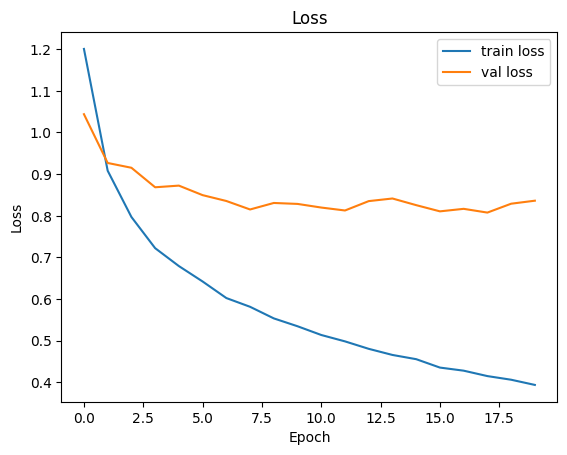

In [22]:
# loss 시각화

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# 에포크 8~10부터 성능 향상 미비함

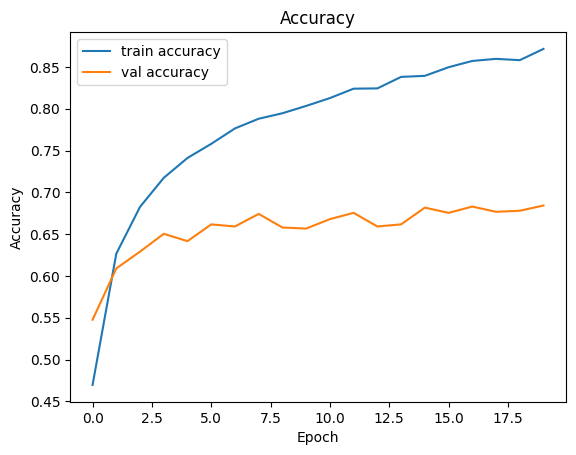

In [23]:
# accuracy 시각화

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# 에포크 8~10부터 성능 향상 미비함

In [24]:
# 하기 사항 반영하여 valid 데이터셋에 대한 성능 증대 도모

# 사전 학습된 베이스 모델의 일부 층을 현재 보유한 데이터에 맞추어 학습
# Dropout 옵션 추가하여 과적합 방지

# -----------------------------------------------------

# 콜백 설정하여 가장 성능 높은 모델 저장 + 학습 조기종료 설정


In [25]:
# 베이스 모델의 일부 층 직접 학습 여부 설정


# 사전 학습된 MobileNetV2 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 마지막 30개 층만 학습 진행
base_model.trainable = False
for layer in base_model.layers[:-30]:  # 마지막 30개 층만 훈련 가능하게 설정
    layer.trainable = False

In [26]:
# 출력층 직전에 Dropout 추가


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # 30% 드롭아웃
output = Dense(train_generator.num_classes, activation='softmax')(x)

In [27]:
# 입력층, 출력층 설정값을 통해 모델 생성

model = Model(inputs=base_model.input, outputs=output)

In [28]:
# 모델 컴파일

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# 손실 함수는 다중 크로스엔트로피 함수
# 성능 지표는 정분류율

In [29]:
# 콜백 설정

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_cb = ModelCheckpoint('best_model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

In [30]:
# 모델 학습

history = model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[checkpoint_cb, early_stopping_cb])
# 성능 확인을 위해 history 변수에 지정

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 331ms/step - accuracy: 0.3515 - loss: 1.5022 - val_accuracy: 0.5426 - val_loss: 1.0556
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.5650 - loss: 1.0283 - val_accuracy: 0.6115 - val_loss: 0.9506
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.6244 - loss: 0.9089 - val_accuracy: 0.6065 - val_loss: 0.9254
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 255ms/step - accuracy: 0.6664 - loss: 0.8432 - val_accuracy: 0.6316 - val_loss: 0.8869
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - accuracy: 0.6667 - loss: 0.8030 - val_accuracy: 0.6316 - val_loss: 0.8710
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.7016 - loss: 0.7383 - val_accuracy: 0.6516 - val_loss: 0.8444
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.7078 - loss: 0.7433 - val_accuracy: 0.6504 - val_loss: 0.8425
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.6933 - loss: 0

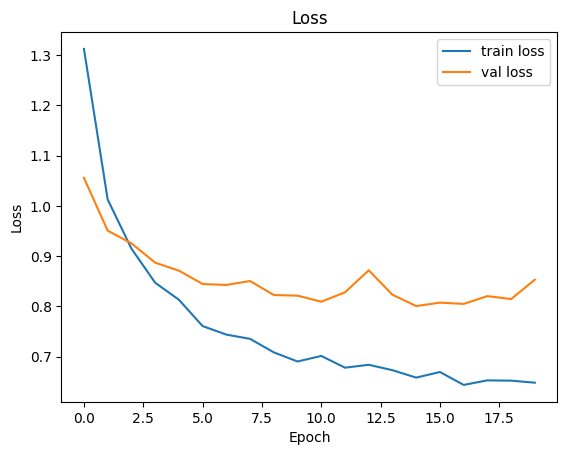

In [31]:
# loss 시각화

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

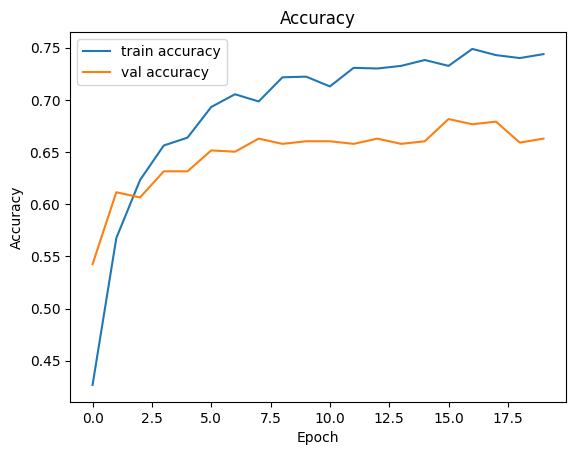

In [32]:
# accuracy 시각화

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 모델 적용

In [35]:
from ultralytics import YOLO
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. 모델 로드
yolo_model = YOLO("/content/best.pt")
emotion_model = load_model("/content/best_model.keras")

# 2. 클래스 이름
class_labels = ['angry', 'happy', 'relaxed', 'sad']

# 3. 이미지 경로 (valid 폴더)
img_paths = glob.glob(
    "/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid/**/*.jpg",
    recursive=True
)

# 4. 결과 저장 폴더
output_dir = "/content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid_results"
os.makedirs(output_dir, exist_ok=True)

# 5. 이미지별 추론 + 시각화 + 저장
for img_path in img_paths:
    results = yolo_model(img_path)[0]
    im = Image.open(img_path).convert("RGB")
    draw = im.copy()
    draw_np = np.array(draw)

    plt.figure(figsize=(8, 8))
    plt.imshow(draw_np)
    ax = plt.gca()

    for i, box in enumerate(results.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)

        # 얼굴 crop 후 전처리
        face = im.crop((x1, y1, x2, y2)).resize((224, 224))
        face_arr = img_to_array(face)
        face_arr = preprocess_input(face_arr)
        face_arr = np.expand_dims(face_arr, axis=0)

        # 감정 예측
        pred = emotion_model.predict(face_arr, verbose=0)
        label = class_labels[np.argmax(pred)]

        # 시각화
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   edgecolor='lime', facecolor='none', linewidth=2))
        ax.text(x1, y1 - 5, label, color='white', fontsize=12, backgroundcolor='black')

    plt.axis('off')

    # 저장할 경로 설정
    filename = os.path.basename(img_path)
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid/images/american_bulldog_102_jpg.rf.d1d722b64d6c5a25f390f2c8f8e3a55f.jpg: 640x640 1 dog, 7.6ms
Speed: 20.8ms preprocess, 7.6ms inference, 408.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예찬 모델링 데이터/dog_face/valid/images/american_bulldog_103_jpg.rf.a83e72bcdc58de1b5983da464e5505ce.jpg: 640x640 1 dog, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/2025 AI+X:딥러닝 프로젝트/3. 데이터/2. 예차